last edited by Claire Valva on September 12, 2018 (and Feb 1, 2019 added the more cohesive detrending section)

# Testing for Fourier/spectral Analysis and related detrending tasks

This notebook tests code that will later be used for spectral analysis. The tasks/exercises throughout are (somewhat in order):

perform FFT and inverse from test functions with known wavenumbers/frequencies

performs FFT on zonal data

compares several detrending techniques on a season (and longitudinal point) of data. the methods tested/compared are: simple linear fit to have first and last entry of the season become equal, linear fit from change in fourier coefficients, EMD (empirical mode decomposition) to find the first trend

In [1]:
#import packages
import numpy as np
from scipy.signal import get_window, csd
from scipy.fftpack import fft, ifft, fftfreq, fftshift, ifftshift
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import matplotlib.cm as cm
from math import pi
import matplotlib.ticker as tck
import datetime
from sympy import solve, Poly, Eq, Function, exp, re, im
from PyEMD import EMD
from netCDF4 import Dataset, num2date # This is to read .nc files and time array
from scipy.optimize import fsolve

## Fast Fourier Transform

the test equations to be used will be  
$\text{wave_f } (\lambda, t)  = 2\cos (2\lambda - t) + 2\sin(3\lambda - 2t)$ and  $\text{wave_g }(\lambda, t)  = 2cos(2\lambda - t) + 3\sin(3\lambda + 2t)$ 



### define functions, spacing and then look at the functions

In [2]:
#define wave function f to be used
def wave_f(wavelength, time):
    cos_part = 2*np.cos(2*wavelength - time)
    sin_part = 2*np.sin(3*wavelength - 2*time)
    return cos_part + sin_part

In [3]:
#define wave function g to be used
def wave_g(wavelength, time):
    cos_part = 2*np.cos(2*wavelength - time)
    sin_part = 2*np.sin(3*wavelength + 2*time)
    return cos_part + sin_part

In [4]:
N = 100 # spacing of data / resolution
N_space1 = 2*pi*np.arange(N)/N # possible spacing
N_space2 = np.arange(N) #possible spacing

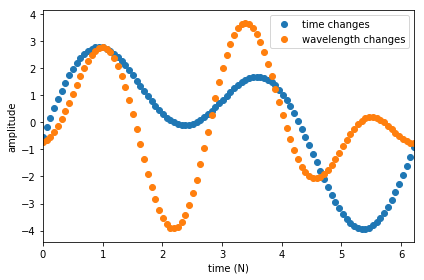

In [5]:
plt.clf();
plt.scatter(N_space1,wave_f(1,N_space1),  label = "time changes")
plt.scatter(N_space1,wave_f(N_space1, 1), label = "wavelength changes")
plt.xlim((N_space1.min(),N_space1.max()))
plt.xlabel('time (N)')
plt.ylabel('amplitude')
plt.legend()
plt.tight_layout()
plt.show()

### apply FFT 

In [6]:
def fft_result_wl(wavelength):
    #applies the fft to the values were wavelength changes
    y = wave_f(wavelength, N_space1)
    ck = 1/N * fft(y)
    return(ck)

In [7]:
def fft_result_time(time):
    #applies the fft to the values were time changes
    y = wave_f(N_space1, time)
    ck = 1/N * fft(y)
    return(ck)

In [8]:
#get fft results
wl_results = [fft_result_wl(item) for item in N_space2]
time_results = [fft_result_time(item) for item in N_space2]

In [9]:
#flatten list for plotting
flat_list_time = [item for sublist in time_results for item in sublist]
flat_list_wl = [item for sublist in wl_results for item in sublist]

In [10]:
#get wavenumbers/frequencies
xf = np.hstack((np.arange(0,N//2), np.arange(-N//2,0) ))
all_xfs = [xf for i in range(N)]
flat_list_xf = [item for sublist in all_xfs for item in sublist]

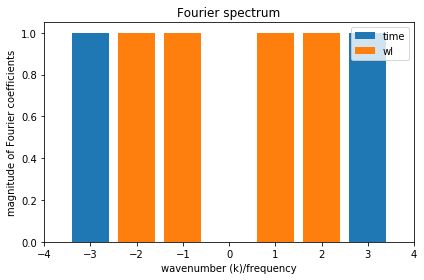

In [11]:
#plot fourier coefficients vs. wavenumber
plt.clf();
plt.bar(flat_list_xf, np.abs(flat_list_time), label = "time")
plt.bar(flat_list_xf, np.abs(flat_list_wl), label = "wl")
plt.title('Fourier spectrum')
plt.xlabel('wavenumber (k)/frequency');
plt.ylabel('magnitude of Fourier coefficients');
plt.legend()
plt.xlim(-4,4)
plt.tight_layout()
plt.show()

## plot as 2D histogram

want to make a 2d histogram where the ck values are the relative frequency ok each wavenumber, this doesn't say very much (as the functions are known and predictable) but wanted to look at 2d hist for future reference

In [12]:
## weights have to be a 1d shape - w_i is the weight of x_i to y_i
hist_weights = [p1+p2 for idx1, 
             p1 in enumerate(np.abs(flat_list_wl)) for idx2, 
             p2 in enumerate(np.abs(flat_list_time)) if idx1==idx2]

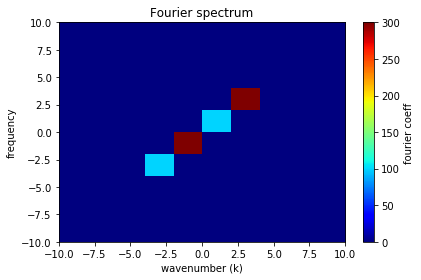

In [13]:
plt.clf();
plt.hist2d(flat_list_xf,flat_list_xf, weights = hist_weights, 
           range = [[-10,10],[-10,10]],
           cmap=plt.cm.jet)
plt.title('Fourier spectrum')
plt.xlabel('wavenumber (k)');
plt.ylabel('frequency');
plt.colorbar(label='fourier coeff')
plt.tight_layout()
plt.show()

## get back original curves with ifft

In [14]:
def ifft_result(transform):
    #function applies ifft to original curve
    y = N * transform
    og = ifft(y)
    return(og)

In [15]:
#apply ifft to both fft of curves
wl_orig = [ifft_result(item) for item in wl_results]
time_orig = [ifft_result(item) for item in time_results]

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


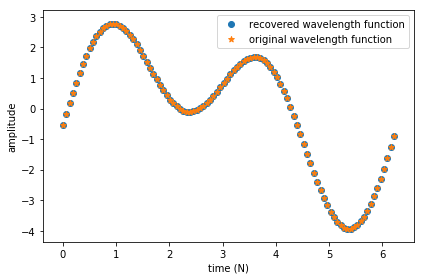

In [16]:
#check if the transform worked
plt.clf();
plt.scatter(N_space1,wl_orig[1], label = "recovered wavelength function")
plt.scatter(N_space1,wave_f(1,N_space1), label = "original wavelength function", marker = "*")
plt.xlabel('time (N)')
plt.ylabel('amplitude')
plt.legend()
plt.tight_layout()
plt.show()

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


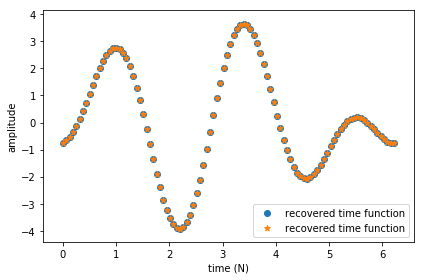

In [17]:
#check if the transform worked
plt.clf();
plt.scatter(N_space1,time_orig[1], label = "recovered time function")
plt.scatter(N_space1,wave_f(N_space1,1), label = "recovered time function", marker = "*")
plt.xlabel('time (N)')
plt.ylabel('amplitude')
plt.legend()
plt.tight_layout()
plt.show()

### try again with second wave function just in case

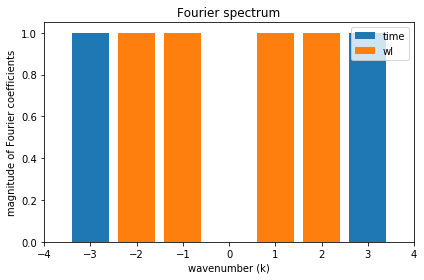

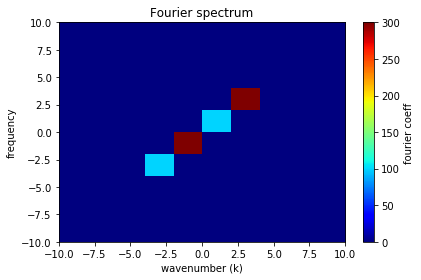

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


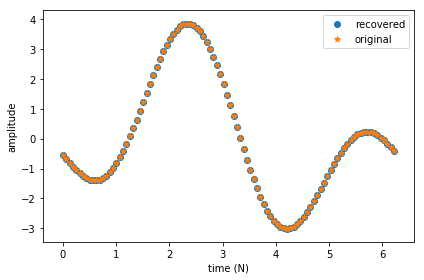

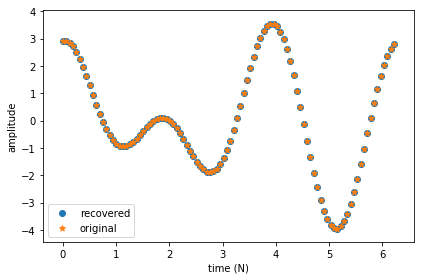

In [18]:
### apply fft
#do it one dimensionally on both first and then with the two d

def fft_result_wl_g(wavelength):
    y = wave_g(wavelength, N_space1)
    ck = 1/N * fft(y)
    return(ck)

def fft_result_time_g(time):
    y = wave_g(N_space1, time)
    ck = 1/N * fft(y)
    return(ck)

#get fft
wl_results = [fft_result_wl_g(item) for item in N_space2]
time_results = [fft_result_time_g(item) for item in N_space2]

#flatten list for plotting
flat_list_time = [item for sublist in time_results for item in sublist]
flat_list_wl = [item for sublist in wl_results for item in sublist]

#get xf points?
xf = np.hstack((np.arange(0,N//2), np.arange(-N//2,0) ))
all_xfs = [xf for i in range(N)]
flat_list_xf = [item for sublist in all_xfs for item in sublist]

plt.clf();
plt.bar(flat_list_xf, np.abs(flat_list_time), label = "time")
plt.bar(flat_list_xf, np.abs(flat_list_wl), label = "wl")
plt.title('Fourier spectrum')
plt.xlabel('wavenumber (k)');
plt.ylabel('magnitude of Fourier coefficients');
plt.legend()
plt.xlim(-4,4)
plt.tight_layout()
plt.show()

## plot as 2D histogram

#want to make a 2d histogram where the ck values are the relative frequency ok each wavenumber

## weights have to be a 1d shape - w_i is the weight of x_i to y_i
hist_weights = [p1+p2 for idx1, 
             p1 in enumerate(np.abs(flat_list_wl)) for idx2, 
             p2 in enumerate(np.abs(flat_list_time)) if idx1==idx2]

plt.clf();
plt.hist2d(flat_list_xf,flat_list_xf, weights = hist_weights, 
           range = [[-10,10],[-10,10]],
           cmap=plt.cm.jet)
plt.title('Fourier spectrum')
plt.xlabel('wavenumber (k)');
plt.ylabel('frequency');
plt.colorbar(label='fourier coeff')
plt.tight_layout()
plt.show()

## get back with ifft

def ifft_result(transform):
    y = N * transform
    og = ifft(y)
    return(og)

wl_og_g = [ifft_result(item) for item in wl_results]
time_og_g = [ifft_result(item) for item in time_results]

plt.clf();
plt.scatter(N_space1,wl_og_g[1], label = "recovered")
plt.scatter(N_space1,wave_g(1,N_space1), label = "original", marker = "*")
plt.xlabel('time (N)')
plt.ylabel('amplitude')
plt.legend()
plt.tight_layout()
plt.show()

plt.clf();
plt.scatter(N_space1,time_og_g[1], label = "recovered")
plt.scatter(N_space1,wave_g(N_space1,1), label = "original", marker = "*")
plt.xlabel('time (N)')
plt.ylabel('amplitude')
plt.legend()
plt.tight_layout()
plt.show()

## Now try with real data

### import file and label properly

In [19]:
#import file
filepath = '/home/clairev/uncategorized-data/1979-2016-300hPa-40.5N-z.nc' # Location of the file
fileobj = Dataset(filepath, mode='r')

# Check what's in there
fileobj

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): longitude(240), time(55520)
    variables(dimensions): float32 z(time,longitude)
    groups: 

In [20]:
#say if want to run the program fresh or use the one from the last run
run_fresh = False

In [21]:
#set indicies/number of things
number_entries = int(fileobj.dimensions['time'].size)
number_days = int(number_entries / 4)
number_lon = fileobj.dimensions['longitude'].size
year_number = 2016 - 1979

In [22]:
#load coordinates
#so height[i] is the geopotential height at a given time
height = fileobj.variables['z'][:]
g = 1/9.81
height = height*g

In [23]:
#create time array
time_list = []
for i in range(0,55520):
    time_list.append(i*6)
tunit = "hours since 1979-01-01T00:00:00Z"
tarray = num2date(time_list,units = tunit,calendar = 'gregorian')

#create longitude array
lon_increment = 1.5 # The increment of each longitude grid is 1.5
lon_list = [i * lon_increment for i in range(240)]

In [24]:
#append season to each row
def season_sort(x):
    if x < 3:
        return("winter")
    elif x >= 12:
        return("winter")
    elif x >= 3 and x < 6:
        return("spring")
    elif x >= 6 and x < 9:
        return("summer")
    elif x >= 9 and x < 12:
        return("fall")
    else:
        return("error?")

In [25]:
if run_fresh:

#get lists and then merge together as a dataframe
    lon_list = [lon_list[k]
               for i in range(number_entries)
               for k in range(number_lon)]

    z_temp = [height[i][k]
              for i in range(number_entries)
              for k in range(number_lon)]

    date_list = [tarray[i]
               for i in range(number_entries)
               for k in range(number_lon)]
    
    #make this a dataframe
    d = {'datetime' : date_list, 'lon': lon_list,
                    'z' : z_temp}
    geopot_df = pd.DataFrame(d)
    
    #get day/month/year separately for groupby
    geopot_df['month'] = geopot_df['datetime'].apply(lambda x: x.month)
    geopot_df['day'] = geopot_df['datetime'].apply(lambda x: x.day)
    geopot_df['year'] = geopot_df['datetime'].apply(lambda x: x.year)
    
    #sort into seasons    
    geopot_df["season"] = geopot_df["month"].apply(lambda x: season_sort(x))
    
    
    # Create storage object with filename `processed_data`
    data_store = pd.HDFStore('processed_data.h5')

    # Put DataFrame into the object setting the key as 'preprocessed_df'
    data_store['preprocessed_geopot'] = geopot_df
    data_store.close()
    
else:
        # Access data store
    data_store = pd.HDFStore('processed_data.h5')

    # Retrieve data using key
    geopot_df = data_store['preprocessed_geopot']
    data_store.close()
        
        

### perform zonal fft

In [26]:
def geopot_fft(geopotential):
    y = fft(geopotential)
    ck = y
    return(ck)

In [27]:
#get fft results at each date over entire longitude
fft_zonal_result = [geopot_fft(height[k]) for k in range(number_entries)]
zonal_spacing = fftfreq(240,1.5)
zonal_spacing = 1/zonal_spacing
zonal_spacing= 360 / zonal_spacing

/home/clairev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [28]:
#flatten the zonal results and spacing/wavenumbers list for plotting
flat_zonal_result = [item for sublist in fft_zonal_result for item in sublist]
all_spacings =  [zonal_spacing for i in range(len(fft_zonal_result))]
flat_zonal_spacing = [item for sublist in all_spacings for item in sublist]

#### FFT over time

first the data has to be detrended because the average will presumably change over time

can use emd, linear, or subtract dA/dt

In [29]:
#first look at one season of the data
toplot_df = geopot_df.query('season == "spring" & year == 1980 & lon == 12')

<Figure size 432x288 with 0 Axes>

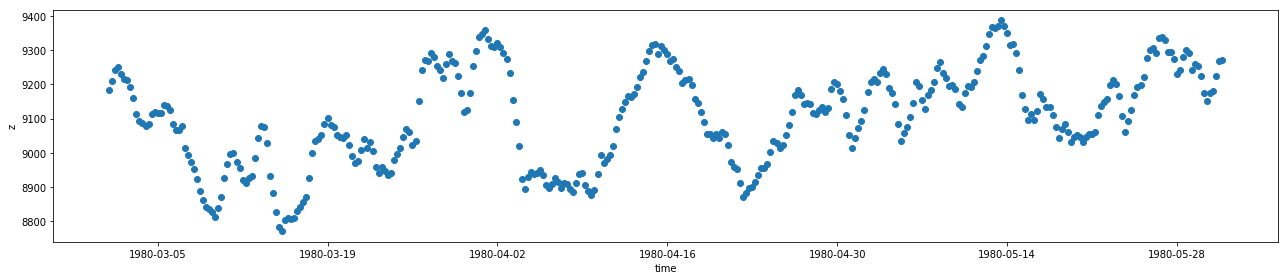

In [30]:
plt.clf();
plt.figure(figsize=(18,4))
plt.plot_date(toplot_df["datetime"], toplot_df["z"])
plt.xlabel('time')
plt.ylabel('z')
plt.tight_layout()

There is clearly some increasing trend with this season, so I will try to isolate and remove it in a few ways.

### EMD

In [31]:
t = np.linspace(0, len(toplot_df["datetime"]), len(toplot_df["datetime"]))

In [32]:
# Execute EMD on signal
# signal is t = toplot_df["datetime"], dz = toplot_df["z"]
# doesn't process timestamps so will get length instead
IMF = EMD().emd(t, toplot_df["z"])
N = IMF.shape[0]+1

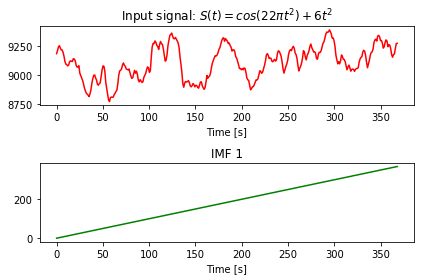

In [33]:
# Plot results
plt.subplot(N,1,1)
plt.plot(t, toplot_df["z"], 'r')
plt.title("Input signal: $S(t)=cos(22\pi t^2) + 6t^2$")
plt.xlabel("Time [s]")

for n, imf in enumerate(IMF):
    plt.subplot(N,1,n+2)
    plt.plot(t, imf, 'g')
    plt.title("IMF "+str(n+1))
    plt.xlabel("Time [s]")

plt.tight_layout()
plt.savefig('simple_example')
plt.show()

In [34]:
#adjust it and see what it looks like
toplot_df["EMD_adjusted"] = toplot_df["z"] - IMF[0] + np.mean(IMF[0])

/home/clairev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<Figure size 432x288 with 0 Axes>

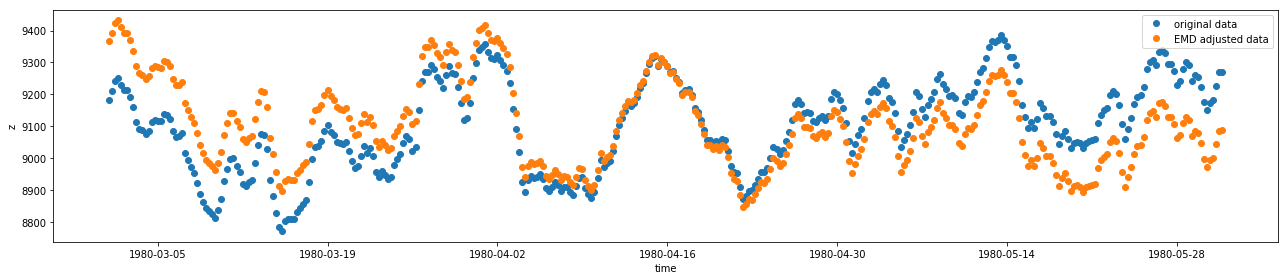

In [35]:
plt.clf();
plt.figure(figsize=(18,4))
plt.plot_date(toplot_df["datetime"], toplot_df["z"], label = "original data")
plt.plot_date(toplot_df["datetime"], toplot_df["EMD_adjusted"], label = "EMD adjusted data")
plt.xlabel('time')
plt.ylabel('z')
plt.legend()
plt.tight_layout()

so while this seems to work nicely, it gives me a pretty linear change, I would love to see how consistent it is,
first alternative I will try is just a simple linear fit to subtract change

### Detrend with simple linear fit

In [36]:
#get difference between first and last entry and extrapolate slope
difference = np.array(toplot_df["z"])[len(toplot_df["z"])-1] - np.array(toplot_df["z"])[0]
slope = difference / len(toplot_df["z"])

#get array of values to subtract
Narray = np.linspace(0, len(toplot_df["datetime"]), len(toplot_df["datetime"]))
tosub = Narray * slope
tosub_withint = tosub - difference/2

#now subtract values 
toplot_df["lin_adjusted"] = toplot_df["z"] - tosub_withint

/home/clairev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

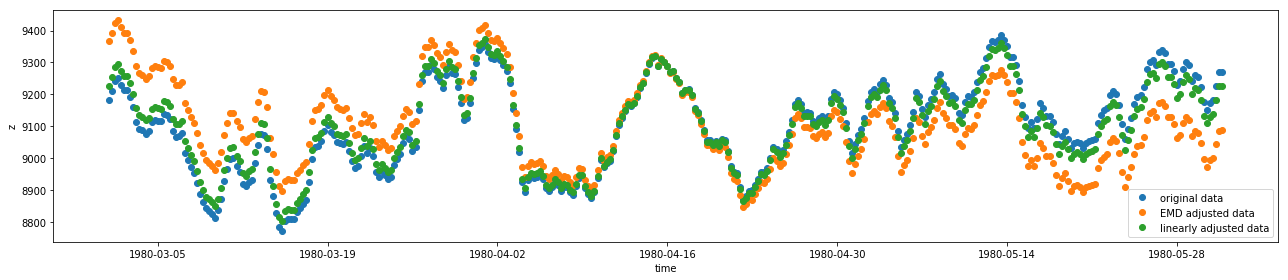

In [37]:
#compare them again!
plt.clf();
plt.figure(figsize=(18,4))
plt.plot_date(toplot_df["datetime"], toplot_df["z"], label = "original data")
plt.plot_date(toplot_df["datetime"], toplot_df["EMD_adjusted"], label = "EMD adjusted data")
plt.plot_date(toplot_df["datetime"], toplot_df["lin_adjusted"], label = "linearly adjusted data")
plt.xlabel('time')
plt.ylabel('z')
plt.legend()
plt.tight_layout()

while nice as it makes the before/after equal and is very simple - the assumption seems too simplistic

### Now try detrending via change in zonal FFT

For each k, write Z in the form $Z(k,t) = A(k,t) \exp(i*\theta(k,t))$, where A and theta are real numbers. Subtract $dA(t) = a*t + b$ from $A(t)$, where $a = (A(t_{max})-A(t_0))/(t_{max} - t_0)$ and $b = - a*(t_{max} - t_0)/2$.

I expect that the largest trends are found in low wavenumbers (k  = 0,1,2) reflecting the seasonal change. 


In [38]:
from scipy.optimize import fsolve

In [39]:
def solve_f(X):
    #function to solve equation
    x,y = X
    f = Zofkt - x*np.exp(1j*y)
    return [np.real(f), np.imag(f)] 

In [40]:
def real_f(X):
    #function to solve equation
    x,y = X
    z = [x+0j,y+0j]
    actual_f = solve_f(z)
    return(actual_f)

In [41]:
tmax = len(toplot_df["datetime"]) - 1
tmin = 0

In [42]:
def fwithZ(time,wavenumber):
    global Zofkt 
    Zofkt = fft_zonal_result[time][wavenumber]
    answers = fsolve(real_f, np.array([0,0]))
    return answers

In [43]:
def arrayforsub(a,b,N):
    #get the correct length 
    Narray = np.linspace(0, N, N)
    tosub = a*Narray + b
    return(tosub)

In [44]:
def gettimeints(timechange):
    hours = timechange.days*24 + timechange.seconds // 3600
    timeints = hours // 6
    return timeints 

In [45]:
def gettimes():
    index_df = list(toplot_df.index)
    
    from_start = list(toplot_df["datetime"])[0] - tarray[0]
    timechange = list(toplot_df["datetime"])[len(index_df)-1] - list(toplot_df["datetime"])[0]
    
    time_ints_fromstart = gettimeints(from_start)
    time_ints_mid = gettimeints(timechange)
    
    return time_ints_fromstart, time_ints_mid

In [46]:
def trendsolver(wavenumber):
    #get first and last timestamp, EDIT
    tmin, tmax = gettimes()
    tmax = tmin + tmax
    
    min_answers = fwithZ(tmin, wavenumber)
    max_answers = fwithZ(tmax, wavenumber)
    
    #solve for slope
    a_top = max_answers[0] - min_answers[0]
    t_diff = tmax - tmin
    a = a_top/t_diff
    
    #solve for intercept
    b = -a*(t_diff)/2
    
    #get the array to later subtract
    array = arrayforsub(a,b,t_diff)
    return(array)

In [47]:
wavenum = 1/zonal_spacing
wavenum = 360 / wavenum

/home/clairev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [48]:
def pairwavenum(i):
    #pairs the wavenumber with the trend array
    trendarray = trendsolver(i)
    wavenumber = wavenum[i]
    
    return(wavenumber,trendarray)

In [49]:
#get trend results at each date over entire longitude
trend_list = [pairwavenum(k) for k in range(len(wavenum))]

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [50]:
max_change = [max(trend_list[i][1]) for i in range(len(trend_list))]

<Figure size 432x288 with 0 Axes>

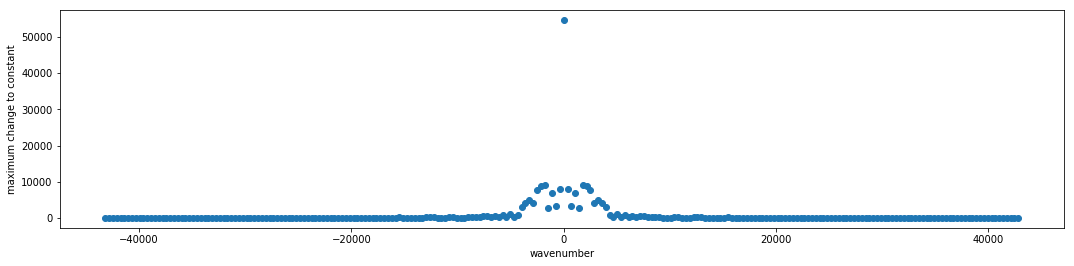

In [51]:
#plot the trends to see what they look like/how big they are
#compare them again!
Narray = np.linspace(0, 367, 367)

plt.clf();
plt.figure(figsize=(18,4))
plt.scatter(x = wavenum, y = max_change)
plt.xlabel('wavenumber')
plt.ylabel('maximum change to constant')
plt.show()

In [52]:
def coeff_subtract(time):
    #get first and last timestamp
    tmin, tmax = gettimes()
    
    #get the time steps at the beginning and end of the seasons
    iter_list = time - tmin
    
    #get the results and then subtract the list
    results = fft_zonal_result[time]
    tosub = [sublist[1][iter_list] for sublist in trend_list]
    
    results = results - tosub
    
    return results

In [53]:
#get the adjusted lists
tmin, tmax = gettimes()
adjusted_list = [coeff_subtract(time) for time in range(tmin,tmax + tmin)]

In [54]:
def ifft_result(transform):
    y = transform
    og = ifft(y)
    return(og)

In [55]:
#perform ifft on the list
adjusted_list_ifft = [ifft_result(adjusted_list[i]) for i in range(len(adjusted_list))]
lon_9_dat = [adjusted_list_ifft[i][100] for i in range(len(adjusted_list_ifft))]

## Compare detrending results
Best/to use: data detrended from the change in fourier coefficients

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

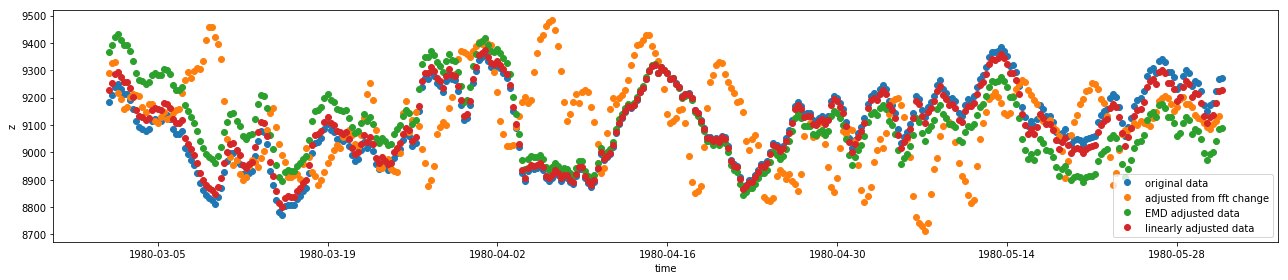

In [56]:
#compare them again!
plt.clf();
plt.figure(figsize=(18,4))
plt.plot_date(toplot_df["datetime"], toplot_df["z"], label = "original data")
plt.plot_date(toplot_df["datetime"][:367], lon_9_dat, label = "adjusted from fft change" )
plt.plot_date(toplot_df["datetime"], toplot_df["EMD_adjusted"], label = "EMD adjusted data")
plt.plot_date(toplot_df["datetime"], toplot_df["lin_adjusted"], label = "linearly adjusted data")
plt.xlabel('time')
plt.ylabel('z')
plt.legend()
plt.tight_layout()

## more cohesive detrending?

is there really an issue? I just don't like how big the corrections are -- but then again big wavenumber = small effect

In [57]:
def trendsolver_edit(wavenumber):
    #get first and last timestamp, EDIT
    tmin, tmax = gettimes()
    tmax = tmin + tmax
    
    min_answers = fwithZ(tmin, wavenumber)
    max_answers = fwithZ(tmax, wavenumber)
    
    #solve for slope
    a_top = max_answers[0] - min_answers[0]
    t_diff = tmax - tmin
    a = a_top/t_diff
    
    #solve for intercept
    b = -a*(t_diff)/2
    
    return a, b

plot a as a contour of time/longitude, also b as a contour of time/longitude 

In [58]:
tested = [leaf[0] for leaf in trend_list]
len(tested)

240

<Figure size 432x288 with 0 Axes>

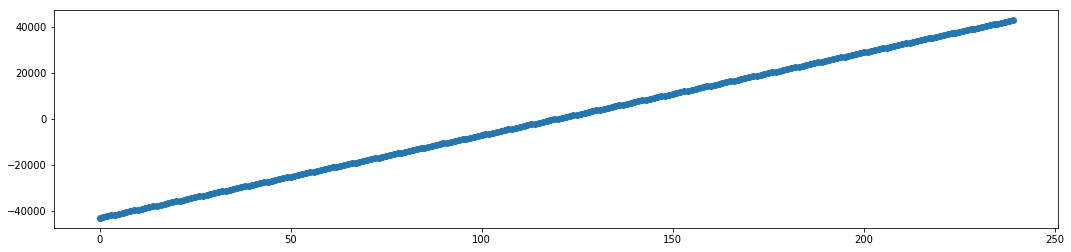

In [59]:
plt.clf();
plt.figure(figsize=(18,4))
plt.scatter(x = list(range(240)), y = fftshift(tested))
plt.show()